__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26 \
Here, HydroLakes are the vectors, not BAWLD. Dataset is much larger and complicated.
TODOL
* rm original HL attributes before download from EE

## I/O

In [3]:
import os
from pathlib import Path
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns
import pyogrio


In [2]:
## I/O
modN = 300000
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/'
os.makedirs(analysis_dir, exist_ok=True)

## Derived
# modstr = 'mod'+str(modN)

In [129]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # NOT 'https://earthengine.googleapis.com'

## Functions

In [130]:
def getRequests():
    ''' Based on unique lat/long indexes in BAWLD'''

    ## Load shapefile to join
    gdf_bawld = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')

    ## For test run: filter only a few tiles
    # gdf_bawld.query("(Lat > 59) and (Lat < 60) and (Long > -109) and (Long < -102)", inplace=True) # comment out

    return gdf_bawld[['Long', 'Lat']].to_numpy()

## testing
# foo = getRequests()
# for f in foo:
#     print(f)

# foo

In [131]:
@retry(tries=7, delay=1, backoff=3) # (tries=10, delay=1, backoff=2) # 7,1,3 causes max delay of 12 min, hopefully enough to clear "service unavailable errors."
def getResult(index, group):
    """
    Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation.
    index is placeholder
    group is an object that represents a unique value within a grouping (e.g. country name, grid cell longitude), and is not related to "group" in function geemap.zonal_statistics_by_group
    """
    ''' TODO: for real, filter to only Arctic X, change scale and tile scale X, change load gdf BB'''
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'HL_zStats_Oc_Long{group[0]}_Lat{group[1]}.csv')

    ## Don't overwrite if starting again
    if os.path.exists(out_pth) or os.path.exists(out_pth+'.txt'):
        return

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load vect and compute mod of ID variable to use for grouping, filtering to high latitudes
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10") #.filter("Pour_lat > 45.0") #.map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectF = vectF.filter("Pour_lat > 59.55").filter("Pour_lat < 59.56") #.filter("Long == -126.25")
    # vect = vect.filter("Hylak_id < 500").filter("Lake_area < 1000")
    
    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence').unmask()

    ## Filter based on bawld cell geometry (note: cells are unequal area)
    # vectF = vect.filter(ee.Filter.eq(modstr, group))
    # groupEE = [ee.Number.float(group[0]) , ee.Number.float(group[1])] # list(map(ee.Number.float, group)) # convert to server object
    vectF = vect.filter(ee.Filter.And(ee.Filter.expression(f"(Pour_long > {group[0]-0.25}) && (Pour_long <= {group[0]+0.25})"), 
        ee.Filter.And(ee.Filter.expression(f"(Pour_lat > {group[1]-0.25}) && (Pour_lat <= {group[1]+0.25})"))))
    nFeats = vectF.size().getInfo()
    print(f'Number of features in chunk: {nFeats}')
    # print(vect.size())
    # print(vectF.size())
    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    if nFeats != 0:
        geemap.zonal_statistics_by_group(
            occurrence,
            vectF,
            out_pth,
            statistics_type='SUM',
            denominator=1000000,
            decimal_places=3,
            crs=crs,
            scale=30, # meters, specifiy to compute at native res (default would be 300m)
            tile_scale=2 # default is 1, increase number to reduce chunking tile size (it won't affect results, but will take longer and use less mem)
        )
        print("Done with group: ", group)
    else:
        print('No features within region filtered by group.')
        Path(out_pth + '.txt').touch()

## Apply functions via GEE calls in parallel

In [6]:
## Testing
# vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)
# print(vect.filter("Hylak_id < 500").filter("Lake_area < 1000").size().getInfo())
# print('Number of features in chunk: ', vect.filter("Hylak_id < 1000").size())
# vect.first().get('mod50')
# vect.propertyNames()
# vect.first().propertyNames() # to actually print the result!
# vect.get('mod50')

In [7]:
## Test on single (Error: property 'element' is required means some filter returned zero. )
# getResult(3, 1)
# getResult(0, np.array([-104.25, 51.25]))

In [8]:
## View expected number of results
items = getRequests()
# print(f'Number of items: {len(items)}')

ERROR 1: PROJ: proj_create_from_database: Open of /home/ekyzivat/mambaforge/envs/geospatial/share/proj failed


In [9]:
print(f'Number of items: {len(items)}')

Number of items: 23469


In [10]:
## Run function
# items = getRequests() # a list whose length is the number of groups to use for parallelizing # np.arange(modN) #
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(30) # 25
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 23469 chunks...
Number of features in chunk: 109
Computing (Hi Ethan!)... 
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 2
Number of features in chunk: 70
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 1
Number of features in chunk: 34
Number of features in chunk: 38
Number of features in chunk: 30
Number of features in chunk: 89
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... 

Number of features in chunk: 2
Computing (Hi Ethan!)... 
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 1
Number of features in chunk: 13
Number of features in chunk: 268
Computing (Hi Ethan!)... 
Number of features in chunk: 0
No features within region filtered by group.
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan

## Load and piece together

In [8]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", assume_missing=True, on_bad_lines='skip', dtype={'system:index': 'object', 'Lake_name': 'object'}) # latter argument suggested by dask error and it fixes it!

In [9]:
## convert to pandas df
df = ddf.compute()
df = df.drop_duplicates(subset='Hylak_id').reset_index().drop('index', axis=1)
df

Class_70  Class_71  Class_72  Class_73  Class_74  Class_75  Class_76  \
0           0.001     0.002     0.000     0.001     0.001     0.000     0.003   
1           0.000     0.000     0.000     0.000     0.000     0.001     0.001   
2           0.003     0.000     0.000     0.001     0.001     0.001     0.000   
3           0.000     0.000     0.000     0.000     0.001     0.001     0.000   
4           0.001     0.000     0.001     0.001     0.000     0.000     0.003   
...           ...       ...       ...       ...       ...       ...       ...   
1112141       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112142       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112143       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112144       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1112145       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         Class_77  Class_sum  Class_8  ...   Dis_avg   Pour_lat  Vol_src  \
0           0.001      0.248    0.000  ...     0.131  50.391481      3.0   
1           0.005      0.253    0.005  ...     3.071  50.121770      3.0   
2           0.003      0.363    0.001  ...     0.005  50.490288      3.0   
3           0.002      0.109    0.001  ...     0.001  50.485042      3.0   
4           0.003      0.154    0.000  ...     0.001  50.357718      3.0   
...           ...        ...      ...  ...       ...        ...      ...   
1112141       NaN      0.374      NaN  ...     0.000  79.639685      3.0   
1112142       NaN      0.480      NaN  ... -9999.000  79.627083      3.0   
1112143       NaN      2.236      NaN  ...     0.695  79.532163      3.0   
1112144       NaN      0.683      NaN  ...     2.251  79.580108      3.0   
1112145       NaN      2.120      NaN  ...     0.002  79.663504      3.0   

         Country  Lake_name          system:index  Class_98  Class_99  \
0         Canada        NaN  001b0000000000004e0d       NaN       NaN   
1         Canada        NaN  001b00000000000051b5       NaN       NaN   
2         Canada        NaN  001b0000000000004c9d       NaN       NaN   
3         Canada        NaN  001b0000000000004cb5       NaN       NaN   
4         Canada        NaN  001b0000000000004e80       NaN       NaN   
...          ...        ...                   ...       ...       ...   
1112141   Russia        NaN  001f0000000000008301       NaN       NaN   
1112142   Russia        NaN  001f0000000000008305       NaN       NaN   
1112143   Russia        NaN  001f00000000000079b8       NaN       NaN   
1112144   Russia        NaN  001f000000000000830d       NaN       NaN   
1112145   Russia        NaN  001f00000000000079b6       NaN       NaN   

         Class_100    {  
0              NaN  NaN  
1              NaN  NaN  
2              NaN  NaN  
3              NaN  NaN  
4              NaN  NaN  
...            ...  ...  
1112141        NaN  NaN  
1112142        NaN  NaN  
1112143        NaN  NaN  
1112144        NaN  NaN  
1112145        NaN  NaN  

[1112146 rows x 125 columns]

## Bin GSW in 4 bins

In [32]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
# oc_column_vals

In [33]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 
bStat

BinnedStatisticResult(statistic=array([[2.000e-03, 1.300e-02, 2.330e-01, 0.000e+00],
       [1.870e-01, 3.500e-02, 3.100e-02, 0.000e+00],
       [1.700e-02, 2.600e-02, 3.200e-01, 0.000e+00],
       ...,
       [2.236e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.830e-01, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.120e+00, 0.000e+00, 0.000e+00, 0.000e+00]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4]))

In [34]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Hylak_id'] = df.Hylak_id
dfB['Class_sum'] = df.Class_sum
dfB 

0-5       5-50      50-95  95-100   Hylak_id  Class_sum
0          0.806452   5.241935  93.951613     0.0   955819.0      0.248
1         73.913043  13.833992  12.252964     0.0   961301.0      0.253
2          4.683196   7.162534  88.154270     0.0   953353.0      0.363
3         19.266055  35.779817  44.954128     0.0   953479.0      0.109
4         12.987013  20.129870  66.883117     0.0   956619.0      0.154
...             ...        ...        ...     ...        ...        ...
1112138  100.000000   0.000000   0.000000     0.0  1119678.0      0.197
1112139  100.000000   0.000000   0.000000     0.0  1119723.0      0.202
1112140  100.000000   0.000000   0.000000     0.0  1119827.0      0.203
1112141  100.000000   0.000000   0.000000     0.0  1119786.0      0.374
1112142  100.000000   0.000000   0.000000     0.0  1119794.0      0.480

[1112143 rows x 6 columns]

In [37]:
## ensure dfB has unique Hylak_id keys
dfB = dfB.drop_duplicates(subset='Hylak_id')

## ensure dfB has unique Hylak_id keys
len(dfB) - len(dfB.drop_duplicates(subset='Hylak_id'))

## Load shapefile and join in GSW values (full and binned)

In [3]:
## Load shapefile to join
gdf = gpd.read_file('/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', bbox=(-180, 40, 180, 90)) # bbox can speed loading


In [14]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Hylak_id' in c) for c in df.columns]]

In [21]:

## Merge files
gdf_join_full = gdf.merge(df[cols_to_keep], left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one')

In [25]:
## view
gdf_join_full.head(2)

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  Grand_id  \
0         2   Great Bear  Canada  North America   CanVec          1         0   
1         3  Great Slave  Canada  North America   CanVec          1         0   

   Lake_area  Shore_len  Shore_dev  ...  Class_43  Class_44  Class_45  \
0   30450.64    5331.72       8.62  ...     0.506     0.493     0.477   
1   26734.29    9814.16      16.93  ...     1.246     1.189     1.224   

   Class_46  Class_47  Class_48  Class_49  Class_98  Class_99  Class_100  
0     0.524     0.505     0.524     0.488    54.255     0.748        NaN  
1     1.236     1.262     1.210     1.177  6267.786  1490.434     39.377  

[2 rows x 124 columns]

In [22]:
## Write out full shapefile (slowww...52 minutes, 3.4 GB)
gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth)

In [23]:
gdf.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [39]:
## Merge binned file to bawld gdf (only keep a few original attributes)
gdf_join_binned = gdf.merge(dfB, left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one') # ['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']
gdf_join_binned

Hylak_id    Lake_name Country      Continent Poly_src  Lake_type  \
0               2   Great Bear  Canada  North America   CanVec          1   
1               3  Great Slave  Canada  North America   CanVec          1   
2               4     Winnipeg  Canada  North America   CanVec          3   
3              10       Ladoga  Russia         Europe    MODIS          1   
4              11       Baikal  Russia         Europe     SWBD          3   
...           ...          ...     ...            ...      ...        ...   
1112134   1354300         None  Russia         Europe     SWBD          1   
1112135   1354316         None  Russia         Europe     SWBD          1   
1112136   1354345         None  Russia         Europe     SWBD          1   
1112137   1356821         None  Russia         Europe     SWBD          1   
1112138   1357252         None  Russia         Europe     SWBD          1   

         Grand_id  Lake_area  Shore_len  Shore_dev  ...  Slope_100  Wshd_area  \
0               0   30450.64    5331.72       8.62  ...      -1.00   147665.4   
1               0   26734.29    9814.16      16.93  ...      -1.00   995312.3   
2             709   23923.04    4018.32       7.33  ...      -1.00   919611.5   
3               0   17444.01    1795.84       3.84  ...      -1.00   279581.2   
4            5058   31967.85    2688.05       4.24  ...      -1.00   569176.2   
...           ...        ...        ...        ...  ...        ...        ...   
1112134         0       0.10       1.38       1.26  ...       5.46        4.7   
1112135         0       0.16       2.73       1.92  ...       6.97        1.5   
1112136         0       0.24       3.73       2.16  ...       7.48        2.1   
1112137         0       0.30       4.63       2.38  ...      13.02       38.1   
1112138         0       0.18       1.94       1.29  ...      11.38        2.8   

          Pour_long   Pour_lat  \
0       -123.505546  65.138384   
1       -117.617115  61.311727   
2        -97.863542  53.696359   
3         31.032851  59.952780   
4        104.321875  52.234393   
...             ...        ...   
1112134  143.565851  46.388284   
1112135  143.586458  46.385559   
1112136  143.593029  46.379939   
1112137  149.792708  45.857083   
1112138  149.677083  45.739339   

                                                  geometry        0-5  \
0        POLYGON ((-119.78782 67.03574, -119.78637 67.0...   0.092034   
1        POLYGON ((-109.93976 62.95851, -109.93831 62.9...   0.232737   
2        POLYGON ((-98.80636 53.88021, -98.80578 53.880...  16.666667   
3        POLYGON ((30.88438 61.74966, 30.88663 61.74813...   3.316583   
4        POLYGON ((109.74514 55.86611, 109.74541 55.865...  33.898305   
...                                                    ...        ...   
1112134  POLYGON ((143.56489 46.38470, 143.56472 46.384...  37.692308   
1112135  POLYGON ((143.58455 46.38664, 143.58522 46.386...  17.857143   
1112136  POLYGON ((143.60276 46.38213, 143.60392 46.380...  12.401055   
1112137  POLYGON ((149.79378 45.85818, 149.79374 45.857...  97.881356   
1112138  POLYGON ((149.68230 45.73857, 149.68250 45.737...   2.956916   

              5-50      50-95     95-100  Class_sum  
0         0.071082  57.810849  42.026024  30656.007  
1         0.198573   4.089538  95.479152  26893.426  
2         7.051282  73.717949   2.564103  24018.110  
3         1.005025  66.080402  29.597990  17544.685  
4         7.627119  51.694915   5.084746  32101.131  
...            ...        ...        ...        ...  
1112134  14.615385  43.076923   0.000000      0.099  
1112135   4.870130  76.298701   0.000000      0.163  
1112136   9.762533  37.467018  39.841689      0.238  
1112137   1.271186   0.847458   0.000000      0.301  
1112138   1.832200  11.709751  83.501134      0.179  

[1112139 rows x 27 columns]

In [55]:
gdf_join_binned.columns
# gdf_join_binned.columns[-6:]
# gdf_join_binned[[-6:]]
# gdf_join_binned.iloc[:,[0, -6:]]
gdf_join_binned[['Hylak_id', 'geometry', '0-5', '5-50', '50-95', '95-100', 'Class_sum']]

Hylak_id                                           geometry  \
0               2  POLYGON ((-119.78782 67.03574, -119.78637 67.0...   
1               3  POLYGON ((-109.93976 62.95851, -109.93831 62.9...   
2               4  POLYGON ((-98.80636 53.88021, -98.80578 53.880...   
3              10  POLYGON ((30.88438 61.74966, 30.88663 61.74813...   
4              11  POLYGON ((109.74514 55.86611, 109.74541 55.865...   
...           ...                                                ...   
1112134   1354300  POLYGON ((143.56489 46.38470, 143.56472 46.384...   
1112135   1354316  POLYGON ((143.58455 46.38664, 143.58522 46.386...   
1112136   1354345  POLYGON ((143.60276 46.38213, 143.60392 46.380...   
1112137   1356821  POLYGON ((149.79378 45.85818, 149.79374 45.857...   
1112138   1357252  POLYGON ((149.68230 45.73857, 149.68250 45.737...   

               0-5       5-50      50-95     95-100  Class_sum  
0         0.092034   0.071082  57.810849  42.026024  30656.007  
1         0.232737   0.198573   4.089538  95.479152  26893.426  
2        16.666667   7.051282  73.717949   2.564103  24018.110  
3         3.316583   1.005025  66.080402  29.597990  17544.685  
4        33.898305   7.627119  51.694915   5.084746  32101.131  
...            ...        ...        ...        ...        ...  
1112134  37.692308  14.615385  43.076923   0.000000      0.099  
1112135  17.857143   4.870130  76.298701   0.000000      0.163  
1112136  12.401055   9.762533  37.467018  39.841689      0.238  
1112137  97.881356   1.271186   0.847458   0.000000      0.301  
1112138   2.956916   1.832200  11.709751  83.501134      0.179  

[1112139 rows x 7 columns]

In [56]:
## Write out binned shapefile (can join in remaining attributes later)
colsKeep = ['Hylak_id', 'geometry', '0-5', '5-50', '50-95', '95-100', 'Class_sum']
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned[colsKeep].to_file(gdf_join_binned_pth)

## Histogram plots

In [4]:
## load if necessary (previously defined vars)
# print('Loading OC_full...')
# gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
# gdf_join_full = pyogrio.read_dataframe(gdf_join_full_pth, use_arrow=True)

print('Loading OC_binned...')
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned = pyogrio.read_dataframe(gdf_join_binned_pth, use_arrow=True)

bin_labels = ['0-5', '5-50', '50-95', '95-100']


Loading OC_binned...


In [6]:
## Preprocess to remove any nan's in important columns
gdf_join_binnedF = gdf_join_binned.dropna(subset=bin_labels) # filtered
print(f'Dropped {gdf_join_binned.shape[0] - gdf_join_binnedF.shape[0]} rows with nans.')

## Averaging method 1: Take weighted average
try:
    weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
except:
    weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Shp_Area'], axis=0)
# weightAvg = np.average(gdf_join_binned[bin_labels], axis=0)

weightAvg

Dropped 0 rows with nans.


array([12.17312464,  7.06818684, 61.88827021, 18.82000502])

In [7]:
## Averaging option B: Sum and then average
dfS = gdf_join_binnedF[bin_labels] /100 * pd.DataFrame(gdf_join_binnedF.loc[:, 'Class_sum']).values # convert percentages back to sums
dfS['Hylak_id'] = gdf_join_binnedF.Hylak_id

## Add area bin
# gdf_join_binnedF['area_bin'] = pd.cut(gdf_join_binnedF.Class_sum, area_bins, labels=area_bins_labels)

## Melt for plotting
dfsM = dfS.melt(id_vars=['Hylak_id'], var_name='Occurrence bin') # 'area_bin' # melted data frame where Occurrence bins represent unweighted MEANS

## Get sums for normalizing second axis
# areaSum = gdf_join_binnedF[bin_labels].sum()

## view
dfS.head(2)

0-5    5-50      50-95     95-100  Hylak_id
0  28.214  21.791  17722.498  12883.501         2
1  62.591  53.403   1099.817  25677.615         3

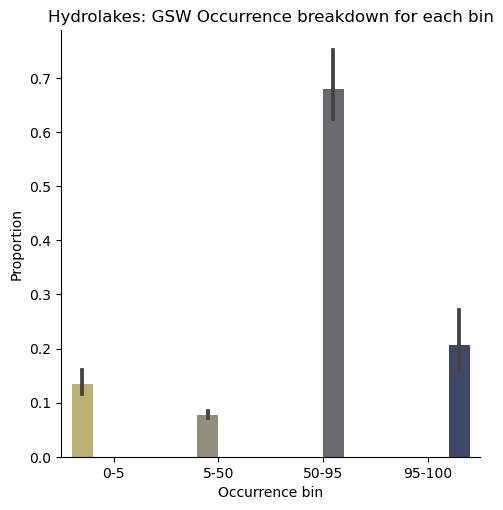

In [8]:
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(dfsM, #.iloc[:1000,:],
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('Occurrence bin', 'Proportion') # Weighted percentage of pixels within bin (%)
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

## Add second y-scale
# ax2 = g.ax.twinx()
# ax2.set_yticklabels()

## Stacked bar plot showing lake size

In [14]:
#3 Very Hydrolakes minimum lake size
np.any(gdf_join_binnedF.Shp_Area < 0.1)

False

In [42]:
## Bin data by lake area
area_bins = pd.IntervalIndex.from_breaks([0.1, 1, 10, 100, np.inf], closed='left')
area_bins_labels = ['0.1-1', '1-10', '10-100', '>100']
gdf_join_binnedF['area_bin'] = pd.cut(gdf_join_binnedF.Shp_Area, area_bins, right=False, labels=area_bins_labels)
gdf_join_binnedF.head(3)

Hylak_id        0-5      5-50      50-95     95-100  Class_sum  Shp_Area  \
0         2   0.092034  0.071082  57.810849  42.026024  30656.007  30450.64   
1         3   0.232737  0.198573   4.089538  95.479152  26893.426  26734.29   
2         4  16.666667  7.051282  73.717949   2.564103  24018.110  23923.04   

                                            geometry      area_bin  
0  POLYGON ((-119.78782 67.03574, -119.78637 67.0...  [100.0, inf)  
1  POLYGON ((-109.93976 62.95851, -109.93831 62.9...  [100.0, inf)  
2  POLYGON ((-98.80636 53.88021, -98.80578 53.880...  [100.0, inf)

In [43]:
## Melt for plotting
dfsM2 = gdf_join_binnedF.drop(columns='geometry').melt(id_vars=['Hylak_id', 'area_bin'], var_name='Occurrence bin') # Melted data frame where occurrence categories are MEAN, not SUM

## group for later on
grouped = dfsM2.groupby(['area_bin', 'Occurrence bin']).mean().reset_index()

## view
dfsM2.groupby(['area_bin', 'Occurrence bin']).sum() # easier to view than the variable grouped, due to og index

Hylak_id         value
area_bin      Occurrence bin                            
[0.1, 1.0)    0-5             691183869779  1.359593e+07
              5-50            691183869779  9.362364e+06
              50-95           691183869779  6.823879e+07
              95-100          691183869779  6.976592e+06
              Class_sum       691183869779  2.695944e+05
              Shp_Area        691183869779  2.682996e+05
[1.0, 10.0)   0-5              10149731485  1.533001e+06
              5-50             10149731485  9.417331e+05
              50-95            10149731485  8.181685e+06
              95-100           10149731485  1.420542e+06
              Class_sum        10149731485  2.980407e+05
              Shp_Area         10149731485  2.962957e+05
[10.0, 100.0) 0-5                 59835371  1.095054e+05
              5-50                59835371  6.661645e+04
              50-95               59835371  5.576729e+05
              95-100              59835371  1.407610e+05
              Class_sum           59835371  2.113562e+05
              Shp_Area            59835371  2.101669e+05
[100.0, inf)  0-5                   414667  8.218294e+03
              5-50                  414667  5.010203e+03
              50-95                 414667  4.195271e+04
              95-100                414667  1.931636e+04
              Class_sum             414667  4.433506e+05
              Shp_Area              414667  4.409711e+05

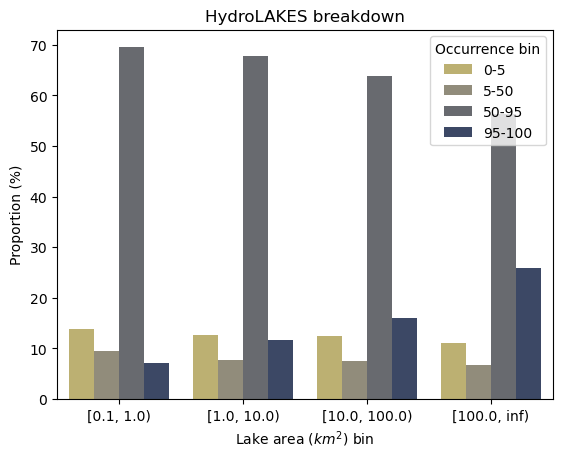

In [44]:
## Plot lakes by double breakdown

## plot colors
plot_colors = ['r','g','b','orange']

## Try stacked bar plots... problem is that I can't add averages, and I can't easily divide dataframes with sum columns and also categorical columns...
# bar3 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[3]) # .query("`Occurrence bin` == '0-5'" #"@np.isin(`Occurrence bin`, ['0-5', '5-50'])"
# bar2 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['50-95','5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[2])
# bar1 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['5-50', '0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[1])
# bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['0-5'])], x="area_bin",  y="value", errorbar=None, color=plot_colors[0])

## Try again (I verified each group sums to 1), can also use barplot or catplot(..., kind='bar')
bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="area_bin",  y="value", hue='Occurrence bin', errorbar=('ci', 95), color=plot_colors[0], palette='cividis_r')
# bar0.set_axis_labels('Proportion (%)', 'Area ($km^2$) bin')
bar0.axes.set_xlabel('Lake area ($km^2$) bin')
bar0.axes.set_ylabel('Proportion (%)')
bar0.axes.set_title('HydroLAKES breakdown')
plt.show()

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/_collections_abc.py:994: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/_collections_abc.py:994: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


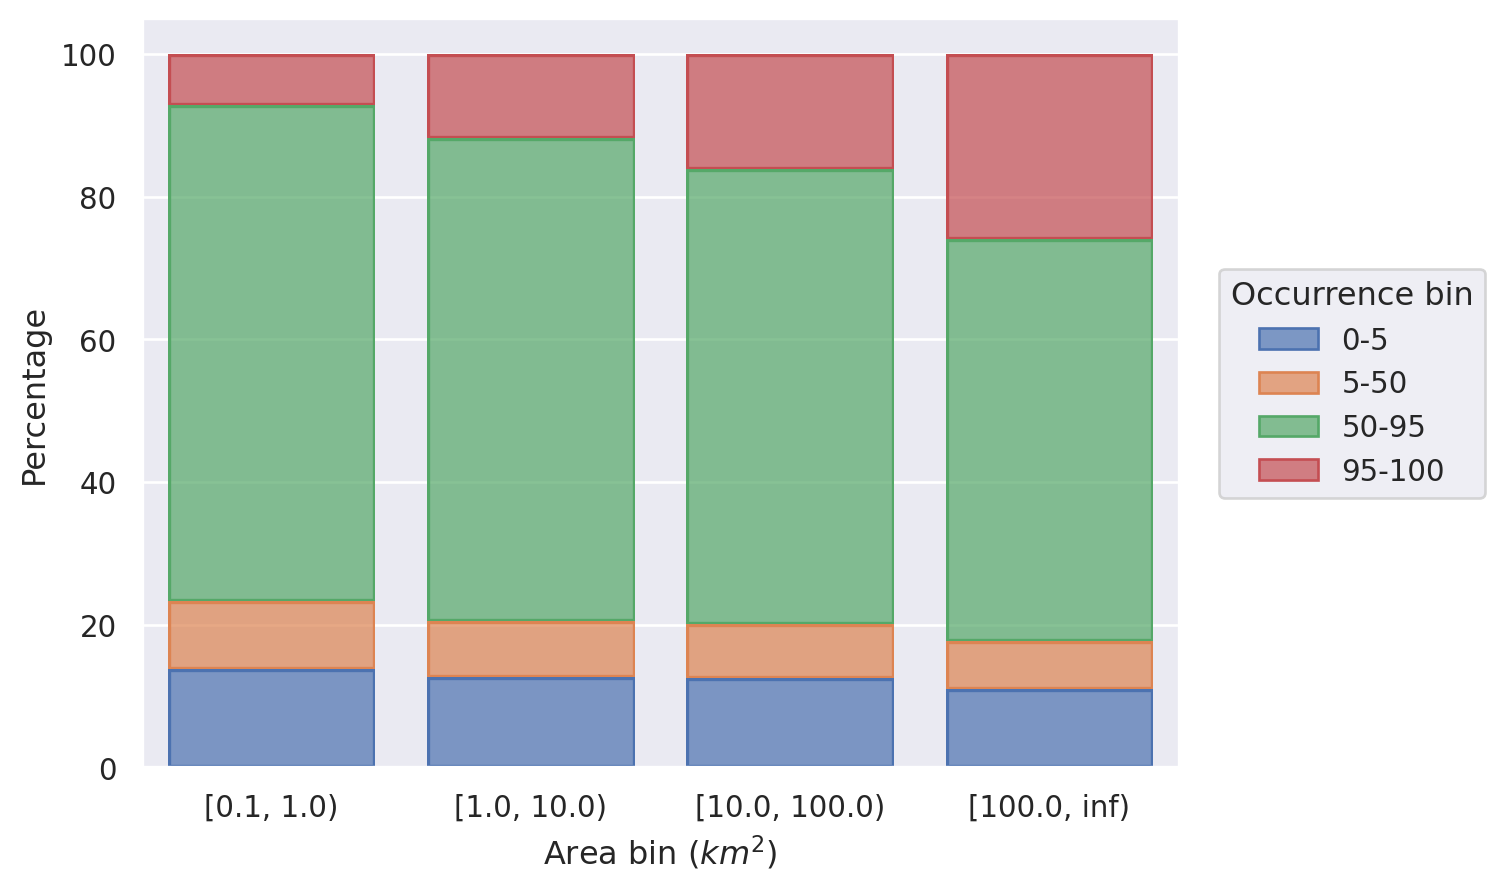

In [56]:
## Actual stacked plot using new sns objects API.
from seaborn import objects as so
sns.set_palette('cividis_r') # doesn't st color map... not sure why...
g = so.Plot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])],
    x="area_bin",  y="value",  color='Occurrence bin').add(so.Bar(), so.Agg(), so.Stack())
# g. ax.set_xlabels(bin_labels)
g.label(x='Area bin ($km^2$)', y='Percentage')
# g.show()

## Scrap

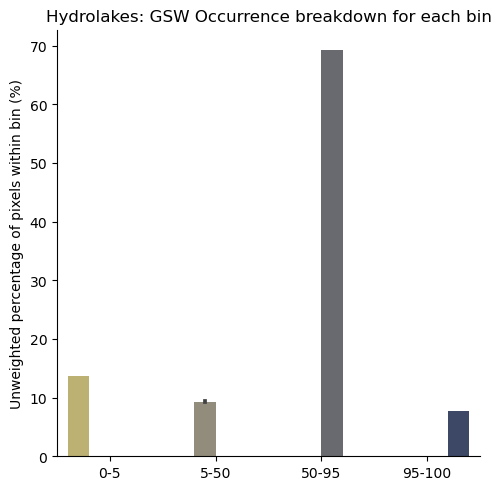

In [ ]:
## Plot
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Hylak_id']+bin_labels].melt(id_vars='Hylak_id', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('', 'Unweighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

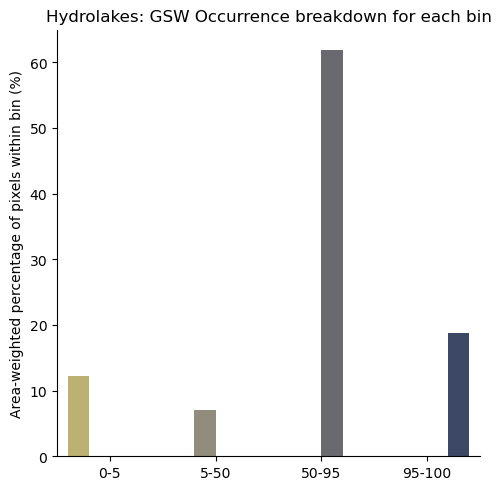

In [ ]:
## Weighted average histogram/barplot without conf intervals
dfWA = pd.DataFrame([weightAvg, bin_labels], index=['value','bin']).T
g = sns.catplot(dfWA, hue = 'bin', y='value', x='bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Area-weighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

Text(0, 0.5, 'Unweighted percentage of pixels within bin (%)')

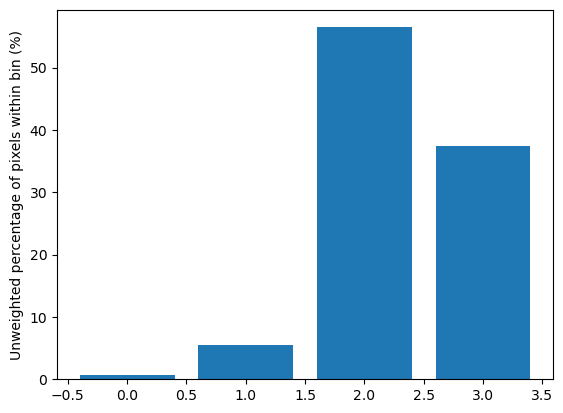

In [ ]:
## Weighted average histogram/barplot (alternate using MPL)

plt.bar(x=np.arange(4), height=weightAvg)
plt.ylabel( 'Unweighted percentage of pixels within bin (%)')


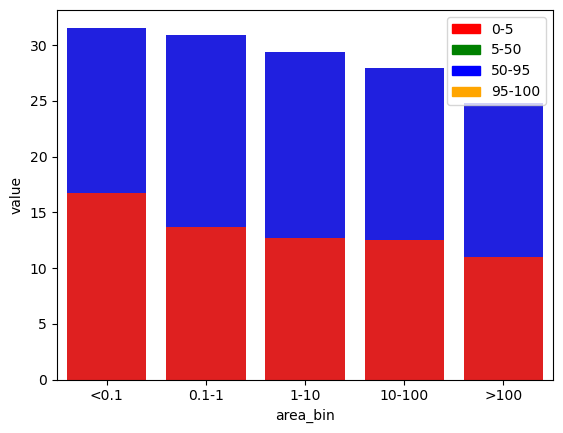

In [ ]:
## Now plot as stacked bar plot (from https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot)
import matplotlib.patches as mpatches

# set plot style: grey grid in the background:
# sns.set(style="darkgrid")

# set the figure size
# plt.figure(figsize=(14, 14))

## plot colors
plot_colors = ['r','g','b','orange']

## small dataset for testing
dfsM2_sub = dfsM2 #.iloc[1::80,:]

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = dfsM2_sub.groupby('area_bin')['value'].mean().reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
# bar_total = sns.barplot(x="area_bin",  y="value", data=total, color=plot_colors[0])
bar_total = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])]

# bottom bar ->  take only smoker=Yes values from the data
bin1 = dfsM2_sub[dfsM2_sub['Occurrence bin']=='0-5']
bin2 = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['5-50', '0-5'])]
bin3 = dfsM2_sub[np.isin(dfsM2_sub['Occurrence bin'], ['50-95','5-50', '0-5'])]
# bin4 = dfsM2_sub[dfsM2_sub['Occurrence bin']=='95-100'] # not needed

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="area_bin", y="value", data=bin1, estimator='mean', errorbar=None,  color=plot_colors[1])
# bar3 = sns.barplot(x="area_bin", y="value", data=bin2, estimator='mean', errorbar=None,  color=plot_colors[2])
# bar4 = sns.barplot(x="area_bin", y="value", data=bin3, estimator='mean', errorbar=None,  color=plot_colors[3])

# simple way of computing remaining bars by addition
total_bin1 = bin1.groupby('area_bin')['value'].mean().reset_index()
total_bin2 = bin2.groupby('area_bin')['value'].mean().reset_index()
total_bin3 = bin3.groupby('area_bin')['value'].mean().reset_index()

# add bar plots for sub totals
bar3 = sns.barplot(x="area_bin",  y="value", data=total_bin3, color=plot_colors[2])
bar2 = sns.barplot(x="area_bin",  y="value", data=total_bin2, color=plot_colors[1])
bar1 = sns.barplot(x="area_bin",  y="value", data=total_bin1, color=plot_colors[0])

# add legend
bars = [mpatches.Patch(color=j, label=bin_labels[i]) for i, j in enumerate(plot_colors)]
# top_bar = mpatches.Patch(color='darkblue', label=bin_labels[0])
# bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=bars)

# show the graph
plt.show()

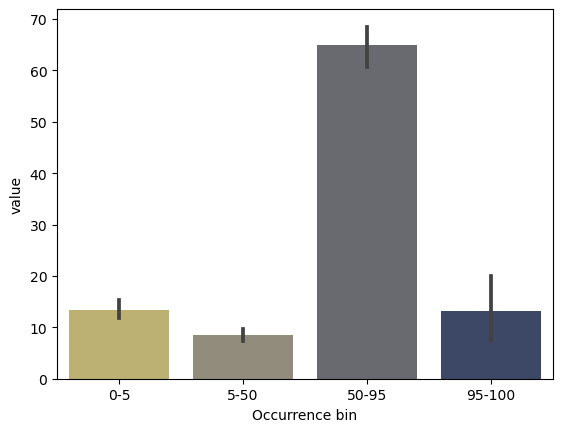

In [ ]:
## Now dubplicate unweighted mean
bar0 = sns.barplot(grouped[np.isin(grouped['Occurrence bin'], ['95-100','50-95','5-50', '0-5'])], x="Occurrence bin",  y="value", errorbar=('ci', 95), color=plot_colors[0], palette='cividis_r')

## Scrap functions

In [ ]:
def getRequests():
    """Generates a list of work items to be downloaded. Should be dquivalent to 'return modN', where modN is mod number.
    """    
    ## Load vector dataset
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectv = vect.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    ## Aggregate by Hylak_id mod
    # return np.unique(vectF.aggregate_array('Country').getInfo()) # change to vect not vectF for real run
    return np.unique(vect.aggregate_array(modstr).getInfo()) # change to vect not vectF for real run

In [ ]:
def getRequests():
    ''' shortcut function that doesn't take 2.5 minutes.'''
    return range(modN)

In [ ]:
def addMod(feature):
    '''Adds a new mod[n] column to FeatureCollection'''
    mod = modN # defined at beginning
    modComputed = ee.Number(feature.get('Hylak_id')).mod(mod) # ee.Number.parse(
    return feature.set('mod'+str(mod), modComputed) # .double()

## ERRORS

```python
Computing (Hi Ethan!)... 
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
HttpError                                 Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py:328, in _execute_cloud_call(call, num_retries)
    327 try:
--> 328   return call.execute(num_retries=num_retries)
    329 except googleapiclient.errors.HttpError as e:

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py:130, in positional.<locals>.positional_decorator.<locals>.positional_wrapper(*args, **kwargs)
    129         logger.warning(message)
--> 130 return wrapped(*args, **kwargs)

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py:938, in HttpRequest.execute(self, http, num_retries)
    937 if resp.status >= 300:
--> 938     raise HttpError(resp, content, uri=self.uri)
    939 return self.postproc(resp, content)

HttpError: <HttpError 400 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "User memory limit exceeded.". Details: "User memory limit exceeded.">

During handling of the above exception, another exception occurred:

EEException                               Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py:6961, in zonal_stats_by_group(in_value_raster, in_zone_vector, out_file_path, statistics_type, decimal_places, denominator, scale, crs, tile_scale, return_fc, verbose, timeout, proxies, **kwargs)
   6960     else:
-> 6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
...
   6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
-> 6964     raise Exception(e)

Exception: User memory limit exceeded.

```python
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 429 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.". Details: "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 73, in retry_decorator
    return __retry_internal(partial(f, *args, **kwargs), exceptions, tries, delay, max_delay, backoff, jitter,
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 33, in __retry_internal
...
    772     return self._value
    773 else:
--> 774     raise self._value

EEException: Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.

Some error about element has a missing property. I treated it like an error caused by returning an empty table/feature collection and it seemed to resolve it.

This happened after 7 hrs of running (with 22,065 files generated)
```python
Downloading data from https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/tables/356e1d94dc202d39f9c68cc224730aa3-c7c5ab24b3d58dd6aa199d1a90b902e0:getFeatures
Please wait ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v2/tiles/HL_zStats_Oc_Long-159.75_Lat55.75.csv
Done with group:  [-159.75   55.75]
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 503 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "The service is currently unavailable.". Details: "The service is currently unavailable.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 6962, in zonal_stats_by_group
    ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 1523, in ee_export_vector
    selectors = ee_object.first().propertyNames().getInfo()
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/computedobject.py", line 98, in getInfo
    return data.computeValue(self)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 764, in computeValue
    return _execute_cloud_call(
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 330, in _execute_cloud_call
...
   6962         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6964 except Exception as e:
-> 6965     raise Exception(e)

Exception: The service is currently unavailable.